In [5]:

import pandas as pd
import qrcode
import os

In [2]:
# Function to generate QR code
def generate_qr_code(url, output_path):
    qr = qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_L, box_size=10, border=4)
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    img.save(output_path)

In [3]:
# Function to create directories if they don't exist
def create_directories(good_dir, bad_dir):
    if not os.path.exists(good_dir):
        os.makedirs(good_dir)
    if not os.path.exists(bad_dir):
        os.makedirs(bad_dir)

In [13]:
# Read CSV file
csv_file = './phishing_site_urls.csv' # Change this to your CSV file name
df = pd.read_csv(csv_file)
# Output directories
good_dir = './QR_codes/good'
bad_dir = './QR_codes/bad'
create_directories(good_dir, bad_dir)

In [14]:
# Generate QR codes
for index, row in df.iterrows():
    if index == 50000: break #Only gets the first 50000 rows
    url = row['URL']
    label = row['Label'] # Assuming column name is 'Label'
    output_path = os.path.join(good_dir if label == 'good' else bad_dir, f'{index}.png')
    generate_qr_code(url, output_path)
print("QR codes generated successfully.")

QR codes generated successfully.


In [26]:
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [30]:
batch_size = 32 
img_height = 76
img_width = 76
qr_path = './QR_codes'

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    qr_path,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    shuffle = True,
    batch_size=batch_size)

Found 50000 files belonging to 2 classes.
Using 40000 files for training.


In [35]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    qr_path,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    image_size=(img_height, img_width),
    shuffle = True,
    batch_size=batch_size)

Found 50000 files belonging to 2 classes.
Using 10000 files for validation.


In [39]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 76, 76, 3)
(32,)


2024-04-03 11:02:34.563359: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model = Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2, activation ='sigmoid', name="outputs")
])

In [43]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [44]:
eps = 5

history = model.fit(
  train_ds,
  epochs=eps
)

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.9519 - loss: 0.1865
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9577 - loss: 0.1589
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.9577 - loss: 0.1545
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.9577 - loss: 0.1534
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.9577 - loss: 0.1504


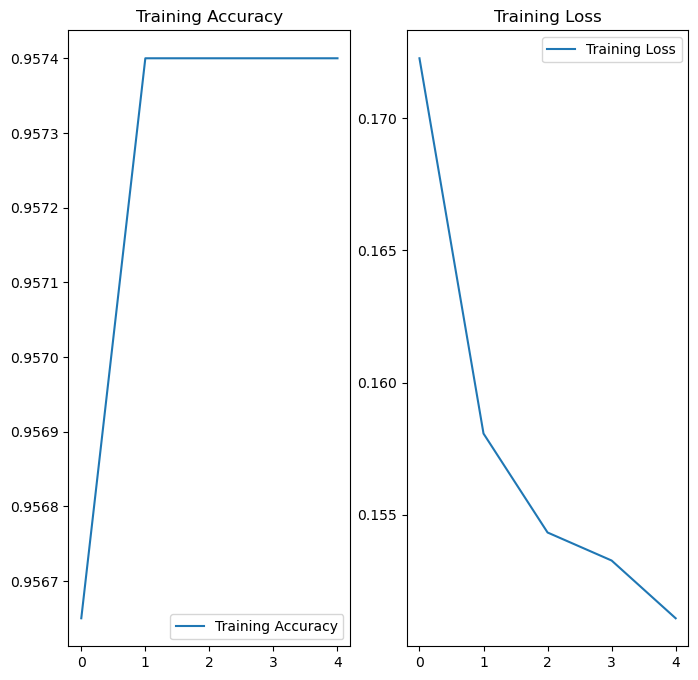

In [47]:
#Visualizing the training and testing accuracy after adding dropout and data augmentation
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(eps)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [48]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

 18/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9535 - loss: 0.1731

/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9598 - loss: 0.1507
Test Accuracy: 96.08%
